# Retrieve Stock Data and Save to DF

In [1]:
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf

def get_stock(ticker, start_date, end_date, s_window, l_window):
    try:
        #yf.pdr_override()
        df = yf.download(ticker, start=start_date, end=end_date,auto_adjust=False)
        #print("DF: ",df)
# can use this as well        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year 
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.day_name()
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        df['Short_MA'] = df['Adj Close'].rolling(window=s_window, min_periods=1).mean()
        df['Long_MA'] = df['Adj Close'].rolling(window=l_window, min_periods=1).mean()        
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 
                    'Week_Number', 'Year_Week', 'Open', 
                    'High', 'Low', 'Close', 'Volume', 'Adj Close',
                    'Return', 'Short_MA', 'Long_MA']
        num_lines = len(df)
        df = df[col_list]
        print('read ', num_lines, ' lines of data for ticker: ' , ticker)
        return df
    except Exception as error:
        print(error)
        return None

In [11]:
try:
    ticker='SPY'
    input_dir = os.getcwd()
    output_file = os.path.join(input_dir, ticker + '.csv')
    df = get_stock(ticker, start_date='2017-01-01', end_date='2025-07-08', 
               s_window=14, l_window=50)
    df.to_csv(output_file, index=False)
    print('wrote ' + str(len(df)) + ' lines to file: ' + output_file)
except Exception as e:
    print(e)
    print('failed to get Yahoo stock data for ticker: ', ticker)

[*********************100%***********************]  1 of 1 completed

read  2138  lines of data for ticker:  SPY
wrote 2138 lines to file: c:\Users\aksha\Documents\BU_RISE\Final_Project\stock-data\SPY.csv



C:\Users\aksha\AppData\Local\Temp\ipykernel_2288\2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)


In [ ]:
#psuedocode
'''
1. create ATR column
2. create SD column
3. build LSTM columnn
4. split into train and test
5. train lstm on training data for ATR and test
6. train lstm on training data for SD and test
7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)
'''

'\n1. create ATR column\n2. create SD column\n3. build LSTM columnn\n4. split into train and test\n5. train lstm on training data for ATR and test\n6. train lstm on training data for SD and test\n7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)\n'

In [17]:
df_n= df.xs('SPY',axis=1,level=1) #.xs returns a cross section; selects only values within the SPY indexes at level=1
df_n.head()
#cleaned up data

Price,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,225.04,225.83,223.88,225.24,91366500,196.12
2017-01-04,225.62,226.75,225.61,226.58,78744400,197.28
2017-01-05,226.27,226.58,225.48,226.40,78379000,197.13
2017-01-06,226.53,227.75,225.90,227.21,71559900,197.83
2017-01-09,226.91,227.07,226.42,226.46,46939700,197.18


In [19]:
import math
#challenge of how to deal with missing values in time series data
#choose sliding window of length=N (could be 20?) N_lstmtraining>N_atrslidingwindow
def atr_func(d):
    running = 0
    for i in range(len(d)):
        high = d.loc[i,"High"]
        low = d.loc[i,"Low"]
        if i==0:
            running += high-low
            continue
        if i>0:
            y_close = d.loc[i,"Close"]
        
        TR = max(high-low,max(math.abs(high-y_close),math.abs(low-y_close)))
        running+=TR
    return running/len(d)

df_n['ATR'] = df_n.rolling(window=14).apply(atr_func)
df_n

IndexingError: Too many indexers

In [ ]:
#define ATR columns
high = df_n["High"]
low = df_n["Low"]
close = df_n["Close"]

prev_close = close.shift(1)


tr = pd.concat([
    high - low,
    (high - prev_close).abs(),
    (low - prev_close).abs()
], axis=1).max(axis=1)

df_n["ATR"] = tr.rolling(7).mean()

C:\Users\aksha\AppData\Local\Temp\ipykernel_2288\3229134450.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()


In [27]:
import numpy as np

log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
df_n["SD_Log_Close"] = log_diff.rolling(7).std()
df_n

C:\Users\aksha\AppData\Local\Temp\ipykernel_2288\3033044218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["SD_Log_Close"] = log_diff.rolling(7).std()


Price,Open,High,Low,Close,Volume,Adj Close,ATR,SD_Log_Close
Date,,,,,,,,
2017-01-03,225.04,225.83,223.88,225.24,91366500,196.12,NaN,NaN
2017-01-04,225.62,226.75,225.61,226.58,78744400,197.28,NaN,NaN
2017-01-05,226.27,226.58,225.48,226.40,78379000,197.13,NaN,NaN
2017-01-06,226.53,227.75,225.90,227.21,71559900,197.83,NaN,NaN
2017-01-09,226.91,227.07,226.42,226.46,46939700,197.18,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-06-30,617.38,619.22,615.04,617.85,92502500,617.85,5.868571,0.005666
2025-07-01,616.36,618.83,615.52,617.65,70030100,617.65,5.398571,0.004345
2025-07-02,617.24,620.49,616.61,620.45,66510400,620.45,4.717143,0.003906


In [39]:
#drop na values (first 6 rows)
df_n = df_n.dropna()
df_n = df_n.reset_index()

In [41]:
(df_n.loc[1,"Date"] - df_n.loc[0,"Date"]).days

1

In [47]:
df_n["Delta_Days"] = [(df_n.loc[i,"Date"] - df_n.loc[0,"Date"]).days for i in range(len(df_n))]

In [114]:
#define lstm model
import torch
from torch.nn import *
import torch.nn.functional as F

class NN_LSTM(Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = LSTM(input_size=input_size,hidden_size=30)
        self.fc = Linear(30,output_size)
    def activation(self,X):
        return F.relu(X)
    def forward(self,input):
        input,_ = self.lstm(input)
        input = self.fc(input[-1,:,:])
        return input #return the last prediction
#lstm_layer = LSTM(input_size=4,hidden_size=30)

In [49]:
#define PDE loss
def PDE_loss(v_hat):
    return 0
    #use torch.autograd to get PDE loss

In [100]:
def tt_split(df_n,vol_metric):
    train = df_n.loc[[i<=len(df_n)*4/5 for i in range(len(df_n))]]
    X_train = train[["Open","Close","High","Low"]].to_numpy()
    y_train = train[vol_metric].to_numpy()

    test = df_n.loc[[i>len(df_n)*4/5 for i in range(len(df_n))]]
    X_test = test[["Open","Close","High","Low"]].to_numpy()
    y_test = test[vol_metric].to_numpy()
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = tt_split(df_n,"ATR")


In [ ]:
def make_seq(X_train,y_train,X_test,y_test):
    T = 30  # sequence length (window size)
    X_seq = []
    y_seq = []
    X_seq_test = []
    y_seq_test = []

    for i in range(len(X_train) - T):
        X_seq.append(X_train[i:i+T])  # shape: [T, 4] <- what is wanted in lstm
        y_seq.append(y_train[i+T])    # predict next ATR value
    for i in range(len(X_test)-T):    
        X_seq_test.append(X_test[i:i+T])
        y_seq_test.append(y_test[i+T])


    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)
    X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
    y_seq_test = torch.tensor(y_seq_test, dtype=torch.float32).unsqueeze(1)
    
    return X_seq,y_seq,X_seq_test,y_seq_test
X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

In [120]:
from torch.utils.data import DataLoader, TensorDataset

def create_loaders(X_seq,y_seq,X_seq_test,y_seq_test,batch_size=64):
    dataset = TensorDataset(X_seq, y_seq)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_test = TensorDataset(X_seq_test,y_seq_test)
    loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=True)
    return loader,loader_test
loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

In [116]:
#training loop
model = NN_LSTM(input_size=4,output_size=1)
epochs = 60
optim = torch.optim.Adam(params = model.parameters())
crit = MSELoss()
losses = []
losses_test = []

for i in range(epochs):
    running_loss = 0
    for x_window,y_atr in loader:
        #print("Running")
        input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
        out = model(input)
        #print(y_atr.shape)
        loss = crit(out,y_atr)
        running_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
            # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
    running_loss/=(len(loader))
    print(f"Training Loss: {running_loss}")
    losses.append(running_loss)

    with torch.no_grad():
        testing_loss = 0
        for x_window_test,y_atr_test in loader_test:
            out_test = model(x_window_test.permute(1,0,2))
            #print(y_atr_test.shape)
            loss = crit(out_test,y_atr_test)
            testing_loss+=loss.item()
        losses_test.append(testing_loss/(len(loader_test)))


Training Loss: 30.9985834757487
Training Loss: 26.051195285938405
Training Loss: 24.20378522519712
Training Loss: 22.162442489906592
Training Loss: 21.673756564105
Training Loss: 18.82260078854031
Training Loss: 17.861312795568395
Training Loss: 16.541908829300493
Training Loss: 15.19481482329192
Training Loss: 13.69721938945629
Training Loss: 12.837032671327945
Training Loss: 12.250276035732693
Training Loss: 11.588001392505786
Training Loss: 11.808012008666992
Training Loss: 10.399848425829852
Training Loss: 10.065310177979645
Training Loss: 10.024542578944454
Training Loss: 9.593825251967818
Training Loss: 9.325894302792019
Training Loss: 9.281861464182535
Training Loss: 9.794601016574436
Training Loss: 8.911570654975044
Training Loss: 9.376995457543266
Training Loss: 8.85840693226567
Training Loss: 8.811235339553267
Training Loss: 8.88979740496035
Training Loss: 9.366097273649993
Training Loss: 8.65828122916045
Training Loss: 9.46364125499019
Training Loss: 8.561747043221086
Traini

<Axes: >

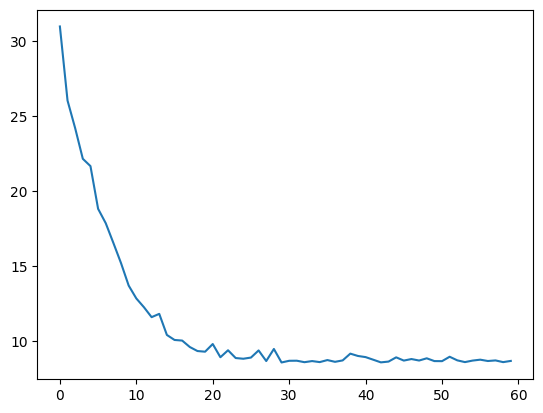

In [117]:
import seaborn as sns

sns.lineplot(x=[i for i in range(len(losses))],y=losses)

<Axes: >

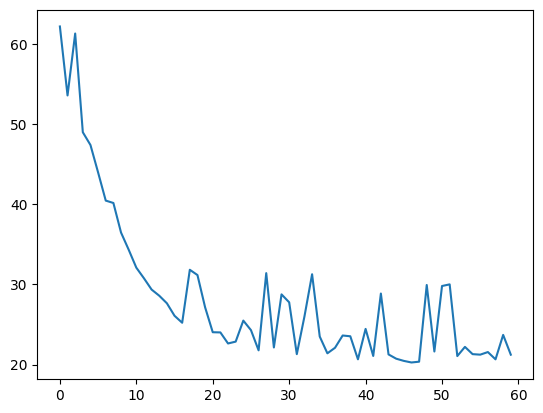

In [118]:
sns.lineplot(x=[i for i in range(len(losses_test))],y=losses_test)

In [122]:
X_train_sd,y_train_sd,X_test_sd,y_test_sd = tt_split(df_n,vol_metric="SD_Log_Close")
X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd = make_seq(X_train_sd,y_train_sd,X_test_sd,y_test_sd)
loader_sd,loader_test_sd = create_loaders(X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd)

In [123]:
#training loop
model_sd = NN_LSTM(input_size=4,output_size=1)
epochs = 60
optim = torch.optim.Adam(params = model_sd.parameters())
crit = MSELoss()
losses = []
losses_test = []

for i in range(epochs):
    running_loss = 0
    for x_window,y_sd in loader_sd:
        #print("Running")
        input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
        out = model_sd(input)
        #print(y_sd.shape)
        loss = crit(out,y_sd)
        running_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
            # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
    running_loss/=(len(loader_sd))
    print(f"Training Loss: {running_loss}")
    losses.append(running_loss)

    with torch.no_grad():
        testing_loss = 0
        for x_window_test,y_sd_test in loader_test_sd:
            out_test = model_sd(x_window_test.permute(1,0,2))
            #print(y_sd_test.shape)
            loss = crit(out_test,y_sd_test)
            testing_loss+=loss.item()
        losses_test.append(testing_loss/(len(loader_test_sd)))


Training Loss: 0.000898944853731707
Training Loss: 7.619460902114278e-05
Training Loss: 6.251129390740836e-05
Training Loss: 6.206997453840881e-05
Training Loss: 6.127288165939885e-05
Training Loss: 6.27185906557349e-05
Training Loss: 6.169266513704012e-05
Training Loss: 6.318791653299101e-05
Training Loss: 6.140495207984242e-05
Training Loss: 6.137238482619136e-05
Training Loss: 6.537651852003937e-05
Training Loss: 6.171691381529888e-05
Training Loss: 6.102387784199824e-05
Training Loss: 6.108033536562559e-05
Training Loss: 6.127760806756905e-05
Training Loss: 6.120523452140063e-05
Training Loss: 6.15839276347456e-05
Training Loss: 6.27972356057769e-05
Training Loss: 6.855206993350293e-05
Training Loss: 6.129504025146296e-05
Training Loss: 6.662142476232946e-05
Training Loss: 6.22032266282649e-05
Training Loss: 6.15653889663345e-05
Training Loss: 6.183497862366494e-05
Training Loss: 6.117506947905188e-05
Training Loss: 6.157388762167775e-05
Training Loss: 6.207476440909818e-05
Trainin

<Axes: >

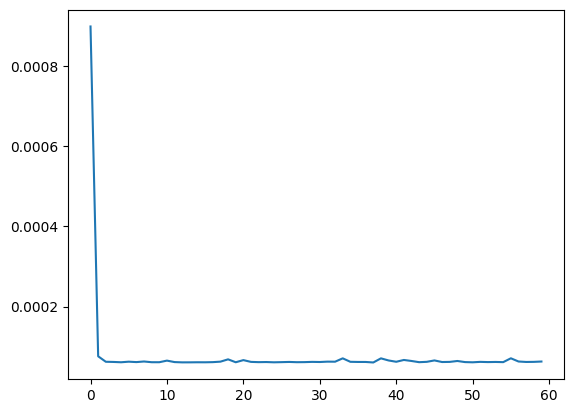

In [125]:
sns.lineplot(losses)

<Axes: >

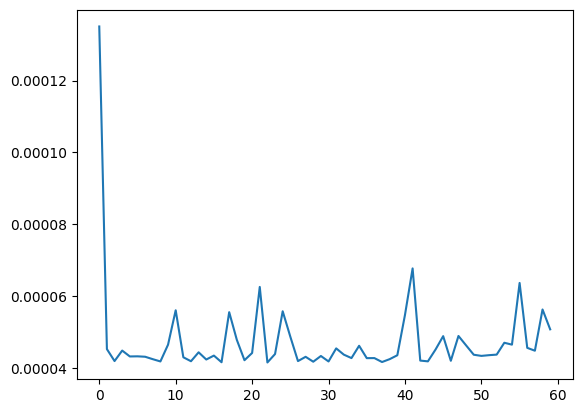

In [126]:
sns.lineplot(losses_test)